<a href="https://colab.research.google.com/github/Mohamedashraf2005/Traffic-Sign_Recognition_PyTorch/blob/main/CV-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **GTSRB - German Traffic Sign Recognition Benchmark - PyTorch**

In [1]:
# !pip install torch torchvision matplotlib


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import time
import copy
import zipfile
import shutil

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
#dataset drive path

dataset_path = "/content/drive/MyDrive/trafficsign_dataset/archive.zip"
os.path.exists(dataset_path)


True

In [ ]:
#extract dataset

zip_path = "/content/drive/MyDrive/trafficsign_dataset/archive.zip"
extract_path = "/content/trafficsign_dataset"

# Check if ZIP exists
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"ZIP file not found at {zip_path}")

# Create extraction folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")
print("Contents:", os.listdir(extract_path))


Dataset extracted successfully!
Contents: ['Train', 'Meta', 'test', 'train', 'Train.csv', 'Test.csv', 'meta', 'Meta.csv', 'Test']


In [ ]:
#contents of dataset
train_path = "/content/trafficsign_dataset/Train"
test_path  = "/content/trafficsign_dataset/Test"

print("Contents of dataset folder:", os.listdir('/content/trafficsign_dataset'))
print("Contents of Train folder:", os.listdir(train_path))
print("Contents of Test folder:", os.listdir(test_path))


Contents of dataset folder: ['Train', 'Meta', 'test', 'train', 'Train.csv', 'Test.csv', 'meta', 'Meta.csv', 'Test']
Contents of Train folder: ['28', '12', '27', '22', '8', '7', '30', '25', '18', '21', '14', '26', '16', '11', '32', '36', '31', '3', '41', '29', '20', '4', '5', '9', '33', '19', '37', '0', '6', '35', '10', '34', '15', '38', '42', '23', '1', '24', '17', '2', '13', '40', '39']
Contents of Test folder: ['09353.png', '01605.png', '00631.png', '02718.png', '06846.png', '05454.png', '08318.png', '11580.png', '00150.png', '01723.png', '05189.png', '06125.png', '02578.png', '00440.png', '01878.png', '07585.png', '05585.png', '07955.png', '06310.png', '01680.png', '03832.png', '06994.png', '00764.png', '02291.png', '06805.png', '08504.png', '09338.png', '01032.png', '06718.png', '04874.png', '08678.png', '02057.png', '05301.png', '06354.png', '09663.png', '11751.png', '08063.png', '09939.png', '09053.png', '09973.png', '04589.png', '03338.png', '01287.png', '00312.png', '00971.png'

In [ ]:
#check to see that Test folder contain images not classes -> error for ImageFolder
# Path to your Test.csv
csv_file = "/content/trafficsign_dataset/Test.csv"

# Load the CSV
df = pd.read_csv(csv_file)

# Display the first few rows
print(df.head())

# Display column names
print("Columns in CSV:", df.columns.tolist())


   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png
Columns in CSV: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']


In [ ]:
#convert Test images to their classes

# Paths
test_folder = "/content/trafficsign_dataset/Test"
csv_file = "/content/trafficsign_dataset/Test.csv"

# Load CSV
df = pd.read_csv(csv_file)

# Create class subfolders and move images
for _, row in df.iterrows():
    filename = os.path.basename(row['Path'])  # extract filename from Path
    class_label = str(row['ClassId'])
    class_folder = os.path.join(test_folder, class_label)

    # Create class folder if it doesn't exist
    os.makedirs(class_folder, exist_ok=True)

    # Move the image into the class folder
    src = os.path.join(test_folder, filename)
    dst = os.path.join(class_folder, filename)

    if os.path.exists(src):
        shutil.move(src, dst)

print("Test folder fixed: images organized into class subfolders.")


Test folder fixed: images organized into class subfolders.


In [ ]:
#preprocessing ,augmentation and dataloader

transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # CV technique – improves generalization
    transforms.RandomRotation(15),                         # CV technique – rotation augmentation
    transforms.RandomHorizontalFlip(),                     # CV technique – flip augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_path = "/content/trafficsign_dataset/Train"
test_path  = "/content/trafficsign_dataset/Test"

# Load datasets
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
test_dataset  = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))


Training samples: 39209
Testing samples: 12630


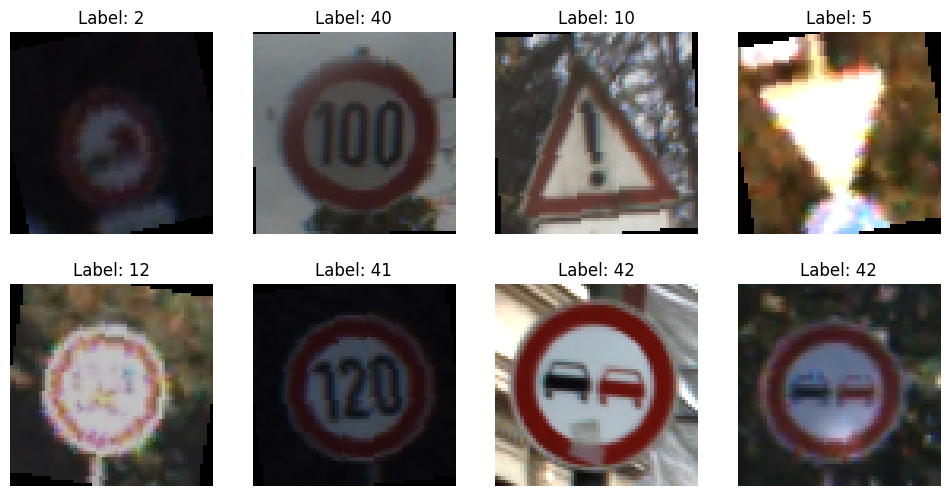

In [ ]:
#sample batch
images, labels = next(iter(train_loader))

plt.figure(figsize=(12, 6))
for i in range(8):
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.show()


# **CNN Model**

In [ ]:
#CNN Model

class TrafficSignCNNEnhanced(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignCNNEnhanced, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 64x64 -> 32x32


            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 32x32 -> 16x16


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 16x16 -> 8x8


            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 8x8 -> 4x4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


### **Transfer Learning using ResNet18, adam Optimizer**

In [ ]:
import os
train_path = "/content/trafficsign_dataset/Train"
classes = os.listdir(train_path)
classes = [c for c in classes if os.path.isdir(os.path.join(train_path, c))]

print("Number of classes:", len(classes))
print("Classes:", classes)

Number of classes: 43
Classes: ['28', '12', '27', '22', '8', '7', '30', '25', '18', '21', '14', '26', '16', '11', '32', '36', '31', '3', '41', '29', '20', '4', '5', '9', '33', '19', '37', '0', '6', '35', '10', '34', '15', '38', '42', '23', '1', '24', '17', '2', '13', '40', '39']


In [ ]:
def resnet_train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25):
    """
    Trains and evaluates the model, incorporating a learning rate scheduler
    that steps based on the test set loss (used as validation loss).
    """
    since = time.time()
    device = next(model.parameters()).device # Get the device the model is on

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print(f"Starting training on device: {device}")

    # Store results for plotting later
    history = {'train_loss': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # -------------------
        # --- Training Phase ---
        # -------------------
        model.train()
        running_loss = 0.0
        running_corrects = 0
        train_size = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            train_size += inputs.size(0)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size

        history['train_loss'].append(epoch_loss)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        # -------------------
        # --- Evaluation Phase (using test_loader as validation) ---
        # -------------------
        model.eval()
        test_running_loss = 0.0
        test_running_corrects = 0
        test_size = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                test_size += inputs.size(0)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                test_running_loss += loss.item() * inputs.size(0)
                test_running_corrects += torch.sum(preds == labels.data)

        test_epoch_loss = test_running_loss / test_size
        test_epoch_acc = test_running_corrects.double() / test_size

        history['test_loss'].append(test_epoch_loss)
        history['test_acc'].append(test_epoch_acc.item())

        print('Test Loss: {:.4f} Acc: {:.4f}'.format(test_epoch_loss, test_epoch_acc))

        # --- Scheduler Step ---
        # Step the scheduler based on the Test Loss (used as validation metric)
        scheduler.step(test_epoch_loss)
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")


        # Deep copy the model if the test accuracy is the best so far
        if test_epoch_acc > best_acc:
            best_acc = test_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
resnet_model = models.resnet18(pretrained=True).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


In [ ]:
num_features = resnet_model.fc.in_features

In [ ]:
for param in resnet_model.parameters():
    param.requires_grad = True

In [ ]:
resnet_model_fc = nn.Linear(num_features, 43).to(device)
# hena el 43 is number of traffic signs classes
resnet_model_fc.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    resnet_model.parameters(), lr=0.0003
    )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,       # reduce LR by 10x
    patience=3,       # wait 3 epochs with no improvement
)

In [ ]:
# def resnet_train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25):

resnet_model = resnet_train_model(resnet_model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=20)

Starting training on device: cuda:0

Epoch 1/20
----------
Train Loss: 0.4633 Acc: 0.8617
Test Loss: 0.2651 Acc: 0.9245
Current LR: 0.000300

Epoch 2/20
----------
Train Loss: 0.1065 Acc: 0.9677
Test Loss: 0.2579 Acc: 0.9356
Current LR: 0.000300

Epoch 3/20
----------
Train Loss: 0.0878 Acc: 0.9737
Test Loss: 0.2598 Acc: 0.9398
Current LR: 0.000300

Epoch 4/20
----------
Train Loss: 0.0624 Acc: 0.9819
Test Loss: 0.1680 Acc: 0.9536
Current LR: 0.000300

Epoch 5/20
----------
Train Loss: 0.0644 Acc: 0.9817
Test Loss: 0.1450 Acc: 0.9598
Current LR: 0.000300

Epoch 6/20
----------
Train Loss: 0.0403 Acc: 0.9888
Test Loss: 0.1909 Acc: 0.9554
Current LR: 0.000300

Epoch 7/20
----------
Train Loss: 0.0454 Acc: 0.9870
Test Loss: 0.1483 Acc: 0.9611
Current LR: 0.000300

Epoch 8/20
----------
Train Loss: 0.0388 Acc: 0.9887
Test Loss: 0.1396 Acc: 0.9651
Current LR: 0.000300

Epoch 9/20
----------
Train Loss: 0.0331 Acc: 0.9904
Test Loss: 0.1684 Acc: 0.9624
Current LR: 0.000300

Epoch 10/20
------